In [2]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from pylab import show, figure
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()


In [52]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent

# The 'extra_arguments' variable requires a value that represents r in the PCTL function defined above.
# The reason it need to be assigned to a seperate variable is that the generic_filter function only allows the
# input function (PCTL in this case) to take one argument (S1). Then, if the input function normally 
# takes more than one argument the 'extra_arguments' variable needs to be defined as a tuple 
# (hence (3,) instead of (3)).
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = (2 * (D*(H**2) + E*(G**2) - (F*G*H))) / (G**2 + H**2)
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def difference_from_mean_elevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def catchmentWindowDicts(window_size, gn, gh_nodes, catchment_area_grid):
    catchment_area_dict = {}
    
    for i in gh_nodes:
        result = np.where(gn == i)
        #################################################################################################
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        subset_row_top = int(row_index - window_size)
        subset_row_bot = int(row_index + window_size) + 1
        subset_col_left = int(col_index - window_size)
        subset_col_right = int(col_index + window_size) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, gn.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, gn.shape[1]);
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(catchment_area_grid);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        #################################################################################################
        highest_value = np.amax(dem_subset)
        catchment_area_dict[i] = highest_value
        
    return catchment_area_dict

In [30]:
input_DEM_resolution = 1
location = (r'C:/PhD/junk')
os.chdir(location)
input_geotiff = gdal.Open('fann_2013_1m.tif')
ig = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
#input_DEM = scipy.ndimage.zoom(x, input_DEM_resolution / initial_resolution, order = 1)
input_DEM = ig
gully_head_layer = gdal.Open('gh_points.tif')
gh = np.array(gully_head_layer.GetRasterBand(1).ReadAsArray())
# This is only required because ArcGIS produced the original grid with 1 as background and 0 as points.
#gully_heads = (gh - 1)**2 

In [31]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [32]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape));

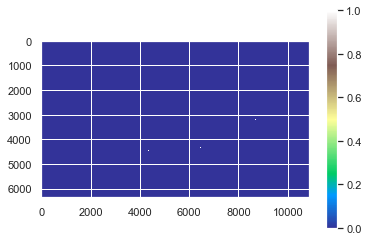

In [33]:
plt.imshow(gh, cmap="terrain");
plt.colorbar();

## Isolate all gully head nodes

In [34]:
find_nodes = np.multiply(gh, grid_nodes);

## Create array of only gully head nodes 

In [35]:
gh_array = np.unique(find_nodes);

## Turn gully head node array into a list and remove the value 0

In [36]:
gh_list = gh_array.tolist();
gh_list.remove(0);

In [45]:
len(gh_list)

689

## Work through list finding index positions of each node

## Still need it to start at highest value in window.

In [38]:
input_geotiff = gdal.Open('fann_D4_1m.tif')
D4 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_D8_1m.tif')
D8 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_Dinf_1m.tif')
Dinf = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_M4_1m.tif')
M4 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_M8_1m.tif')
M8 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

In [65]:
D4_dict = catchmentWindowDicts(1, grid_nodes, gh_list, D4)

In [66]:
D8_dict = catchmentWindowDicts(1, grid_nodes, gh_list, D8)

In [67]:
Dinf_dict = catchmentWindowDicts(1, grid_nodes, gh_list, Dinf)

In [68]:
M4_dict = catchmentWindowDicts(1, grid_nodes, gh_list, M4)

In [69]:
M8_dict = catchmentWindowDicts(1, grid_nodes, gh_list, M8)

In [70]:
ds = [D4_dict, D8_dict, Dinf_dict, M4_dict, M8_dict]
d = {}
for k in D4_dict.keys():
    d[k] = tuple(d[k] for d in ds)

In [71]:
catchment_areas_dataframe = pd.DataFrame.from_dict(d, orient='index')

In [72]:
catchment_areas_dataframe.rename(columns={0: 'D4', 1: 'D8', 2: 'Dinf', 3: 'M4', 4: 'M8'}, inplace=True)

In [73]:
catchment_areas_dataframe.head()

,D4,D8,Dinf,M4,M8
4651564,0.5063,0.3018,0.314625,0.391380,0.364150
4988699,0.5557,0.5695,0.599485,0.521886,0.583439
5543065,0.1638,0.1708,0.206667,0.286417,0.265422
6391156,0.7905,0.3779,0.408395,0.568622,0.449817
6543433,0.0896,0.0371,0.124750,0.125946,0.131077


In [74]:
c = catchment_areas_dataframe.corr()

[Text(0, 0.5, 'D4'),
 Text(0, 1.5, 'D8'),
 Text(0, 2.5, 'Dinf'),
 Text(0, 3.5, 'M4'),
 Text(0, 4.5, 'M8')]

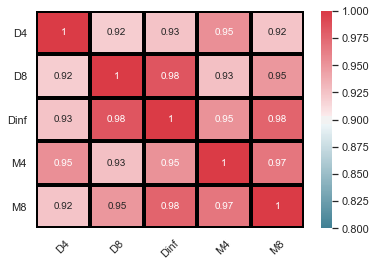

In [75]:
comparison = sns.heatmap(c, xticklabels=c.columns, 
                         yticklabels=c.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin = 0.8, vmax = 1, linecolor = 'black', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

In [33]:
isolate_catchment_area_nodes = np.isin(grid_nodes, catchment_area_node_list).astype(int)

In [ ]:
np.unique(isolate_catchment_area_nodes)

In [ ]:
plt.imshow(isolate_catchment_area_nodes, cmap="terrain");
plt.colorbar();

In [35]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [36]:
np_array_to_Geotiff('test_nodes.tif', input_geotiff, isolate_catchment_area_nodes, input_DEM.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.
